In [51]:
# %load_ext autoreload
# %autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
#sys.path.append('/beegfs/desy/user/akorol/projects/point-cloud-diffusion/')

/tmp/ipykernel_123221/401575653.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [52]:
print('hi')

hi


In [53]:
import math
import argparse
import h5py
import importlib
import numpy as np
import torch
import time
import sys
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

from models.vae_flow import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from models.shower_flow import compile_HybridTanH_model
from configs import Configs
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, Xmax, Xmin, Zmax, Zmin
import utils.gen_utils as gen_utils


import k_diffusion as K


cfg = Configs()

print(cfg.__dict__)

{'name': 'CD_', 'comet_project': 'calo-consistency', 'Acomment': 'long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA', 'log_comet': True, 'model_name': 'epicVAE_nFlow_kDiffusion', 'latent_dim': 0, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 0.001, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hid_d': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'dataset': 'x36_grid', 'dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': F

# Shower Flow Model

In [54]:
flow, distribution = compile_HybridTanH_model(num_blocks=10, 
                                        #    num_inputs=32, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                          #  num_inputs=35, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_inputs=65, ### adding 30 e layers 
                                           num_cond_inputs=1, device=cfg.device)  # num_cond_inputs

# checkpoint = torch.load('/beegfs/desy/user/akorol/chekpoints/ECFlow/EFlow+CFlow_138.pth')
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220706_cog_ShowerFlow_350.pth')
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220707_cog_ShowerFlow_500.pth')  # max 730
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220713_cog_e_layer_ShowerFlow_best.pth') 
checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220714_cog_e_layer_ShowerFlow_best.pth')   # trained about 350 epochs
flow.load_state_dict(checkpoint['model'])
flow.eval().to(cfg.device)

print('flow model loaded')

flow model loaded


# Diffusion Model

In [55]:
# from models.allCond_epicVAE_nflow_PointDiff import AllCond_epicVAE_nFlow_PointDiff
# from models.epicVAE_nflows_kDiffusion import epicVAE_nFlow_kDiffusion

import models.epicVAE_nflows_kDiffusion as mdls
import models.allCond_epicVAE_nflow_PointDiff as mdls2
# importlib.reload(mdls)
# importlib.reload(mdls2)


# cfg.sched_mode = 'quardatic'
# cfg.num_steps = 100
# cfg.residual = True
# cfg.latent_dim = 256
# model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic
# model.load_state_dict(checkpoint['state_dict'])





# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_24__14_54_09/ckpt_0.000000_500000.pt')    # EDM BASELINE first training
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_31__17_57_11/ckpt_0.000000_1690000.pt')  # max 1760000

# cfg.model['sigma_data'] = 0.08
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_01__13_28_09/ckpt_0.000000_340000.pt')  # too wide cog_Y, too low hit_E

# RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_43_14/ckpt_0.000000_258000.pt')

# # RAdam optimizer, 2M iterations, scheduler from 300k-2M, EMApower 0.6667 - sigma_data=0.25
# cfg.model['sigma_data'] = 0.25
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__15_55_11/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=1e-4, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_40_41/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=True, lr=2e-3, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = True
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_36_04/ckpt_0.000000_920000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_03__10_24_31/ckpt_0.000000_737000.pt')

# # "sigma_data" : [0.08, 0.35, 0.08, 0.5]
# cfg.model['sigma_data'] = [0.08, 0.35, 0.08, 0.5]
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_27_15/ckpt_0.000000_300000.pt')

# # "sigma_data = 1
# cfg.model['sigma_data'] = 1.
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_28_38/ckpt_0.000000_280000.pt')

# # ""sigma_data = 0.1
# cfg.model['sigma_data'] = 0.1
# cfg.dropout_rate = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__13_34_50/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.05
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.05
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__14_21_41/ckpt_0.000000_320000.pt')

# # "sigma_data = 0.5, dropout=0.025
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_36_04/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.01
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.01
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_35_01/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=32
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__17_36_22/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=8
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 8
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__14_59_24/ckpt_0.000000_500000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=2
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 2
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__19_23_03/ckpt_0.000000_500000.pt')

# baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-5
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__14_54_11/ckpt_0.000000_410000.pt')

# # baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-6
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__16_12_53/ckpt_0.000000_410000.pt')

# # baseline with lat_dim = 256, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l1
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__14_42_09/ckpt_0.000000_500000.pt')  

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l2
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__18_55_23/ckpt_0.000000_500000.pt')  

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.1
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.1
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__13_58_28/ckpt_0.000000_325000.pt')   

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.05
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.05
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__13_55_49/ckpt_0.000000_310000.pt')  

# baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.025
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__14_04_11/ckpt_0.000000_330000.pt')  

# # baseline with lat_dim = 0, max_iter 10M, lr=1e-3 fixed, dropout_rate=0.0, ema_power=2/3 (long training)   # DROPPED TO 1e-4 lr
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_09_03/ckpt_0.000000_3000000.pt')  

# # # baseline with lat_dim = 0, max_iter 10M, lr=1e-4 fixed, dropout_rate=0.0, ema_power=2/3 (long training)            USING THIS TRAINING
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_08_31/ckpt_0.000000_2000000.pt')    # max 5200000

# baseline with lat_dim = 32, max_iter 10M, lr=1e-3 FIXED, dropout_rate=0.0, ema_power=2/3 (long training)
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_07_02__20_28_57/ckpt_0.000000_2140000.pt')  

# baseline with lat_dim = 32, max_iter 10M, lr=1e-4 FIXED, dropout_rate=0.0, ema_power=2/3 (long training)
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_07_02__20_30_03/ckpt_0.000000_2170000.pt')  


# model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
# model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])

#  load model with torch load with name "model_ema


# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_570000.pt') #worst cog x
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_748000.pt') #best cog x

# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_sigmoid2023_04_06__16_35_47/ckpt_0.000000_849000.pt') # sigmoid 
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic



# CONSISTENCY MODESL

# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-3 fixed, num_steps=18, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_28_07/ckpt_0.000000_650000.pt') 
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256  sigma_max=80             GOOOOOD
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_30_39/ckpt_0.000000_1000000.pt')
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=40, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_31_45/ckpt_0.000000_695000.pt')
# long baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=10, epoch=1.69M, not EMA
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_02__21_08_51/ckpt_0.000000_1000000.pt')

# long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_07__16_32_09/ckpt_0.000000_1000000.pt')   # max 1200000


# model = mdls.epicVAE_nFlow_kDiffusion(cfg, distillation = True).to(cfg.device)
# model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])




# model.eval()

# print('model loaded')

In [56]:
caloclouds = 'cm'   # 'ddpm, 'edm', 'cm'


# caloclouds baseline
if caloclouds == 'ddpm':
    kdiffusion=False   # EDM vs DDPM diffusion
    cfg.sched_mode = 'quardatic'
    cfg.num_steps = 100
    cfg.residual = True
    cfg.latent_dim = 256
    model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
    checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt', map_location=torch.device(cfg.device)) # quadratic
    model.load_state_dict(checkpoint['state_dict'])
    coef_real = np.array([ 2.50244046e-09, -2.82685784e-05,  3.15731003e-01,  5.08123555e+01])
    coef_fake = np.array([ 3.72975819e-09, -3.87472364e-05,  3.80314204e-01,  5.30334567e+01])

# caloclouds EDM
elif caloclouds == 'edm':
    kdiffusion=True   # EDM vs DDPM diffusion
    # # # baseline with lat_dim = 0, max_iter 10M, lr=1e-4 fixed, dropout_rate=0.0, ema_power=2/3 (long training)            USING THIS TRAINING
    cfg.dropout_rate = 0.0
    cfg.latent_dim = 0
    checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_08_31/ckpt_0.000000_2000000.pt', map_location=torch.device(cfg.device))    # max 5200000
    model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
    model.load_state_dict(checkpoint['others']['model_ema'])
    coef_real = np.array([ 2.50244046e-09, -2.82685784e-05,  3.15731003e-01,  5.08123555e+01])
    coef_fake = np.array([ 5.08021809e-09, -5.26101363e-05,  4.74959822e-01,  5.34314449e+01])

# condsistency model
elif caloclouds == 'cm':
    kdiffusion=True   # EDM vs DDPM diffusion
    # long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA
    cfg.dropout_rate = 0.0
    cfg.latent_dim = 0
    checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_07__16_32_09/ckpt_0.000000_1000000.pt', map_location=torch.device(cfg.device))   # max 1200000
    model = mdls.epicVAE_nFlow_kDiffusion(cfg, distillation = True).to(cfg.device)
    model.load_state_dict(checkpoint['others']['model_ema'])
    coef_real = np.array([ 2.50244046e-09, -2.82685784e-05,  3.15731003e-01,  5.08123555e+01])
    coef_fake = np.array([ 4.29894066e-09, -4.61132724e-05,  4.40193379e-01,  6.23006887e+01])

else:
    raise ValueError('caloclouds must be one of: ddpm, edm, cm')

model.eval()

print(caloclouds, ' model loaded')

cm  model loaded


In [57]:
importlib.reload(gen_utils)

torch.manual_seed(12345)

# kdiffusion=True   # EDM vs DDPM diffusion
cfg.num_steps = 13
cfg.sampler = 'heun'   # default 'heun'
cfg.s_churn =  0.0     # stochasticity, default 0.0  (if s_churn more than num_steps, it will be clamped to max value)
cfg.s_noise = 1.0    # default 1.0   # noise added when s_churn > 0
cfg.sigma_max = 80.0 #  5.3152e+00  # default 80.0
cfg.sigma_min = 0.002   # default 0.002
cfg.rho = 7. # default 7.0

# CaloClouds
# coef_real = np.array([ 2.57988645e-09, -2.94056522e-05,  3.42194568e-01,  5.34968378e+01])
# coef_fake = np.array([ 3.85057207e-09, -4.16463897e-05,  4.19800713e-01,  5.82246858e+01])

# kCaloClouds_2023_05_24__14_54_09_heun18
# coef_real = np.array([ 2.39735048e-09, -2.69842295e-05,  2.96136986e-01,  4.89770787e+01])
# coef_fake = np.array([ 4.45753201e-09, -4.26483492e-05,  4.03632976e-01,  6.31063427e+01])

# kCaloClouds_2023_05_24__14_54_09_heun13
# coef_real = np.array([ 2.39735048e-09, -2.69842295e-05,  2.96136986e-01,  4.89770787e+01])
# coef_fake = np.array([ 5.72940149e-09, -4.76120436e-05,  4.37720799e-01,  5.97962496e+01])

n_scaling = True

s_t = time.time()
fake_showers_3 = gen_utils.gen_showers_batch(model, distribution, 50, 50, 2000, bs=16, kdiffusion=kdiffusion, config=cfg, coef_real=coef_real, coef_fake=coef_fake, n_scaling=n_scaling)
t = time.time() - s_t
print(fake_showers_3.shape)
print(t)
print('time per shower: ', t / 2000)

  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:01<00:00, 66.77it/s]


(2000, 4, 6000)
2.2804484367370605
time per shower:  0.0011402242183685303


In [58]:
# sigmas = K.sampling.get_sigmas_karras(cfg.num_steps, cfg.sigma_min, cfg.sigma_max, rho=cfg.rho)
# print(sigmas)


In [59]:
# %%timeit
# with torch.no_grad():
#     fake_showers = get_shower(4000, 50, 50)

In [60]:
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy', fake_showers)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_10-90GeV_40k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_10-90GeV_40k.npy', fake_showers_3)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy', fake_showers_3)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_heun13_50GeV_2k.npy', fake_showers_3)  # seed 123

# for n hits calibration (n_scaling=False)
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k.npy', fake_showers_3)  # seed 1234  # new flow: 220714_cog_e_layer_ShowerFlow_best
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k.npy', fake_showers_3)  # seed 1234 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k.npy', fake_showers_3)  # seed 1234 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# Plots

In [61]:
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, plt_cog
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting

import numpy as np
import h5py
import matplotlib.pyplot as plt

In [62]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/50GeV_x36_grid_regular_2k_Z4.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular_float32.hdf5'
# path = '/beegfs/desy/user/akorol/projects/getting_high/ILDConfig/StandardConfig/production/out/10GeV_x36_grid_regular_2k_Z4_grid_pos_rundom.hdf5'
real_showers = h5py.File(path, 'r')['events'][:]

# dequantization
# offset = 5.0883331298828125 / 6 # size of x36 granular grid
# pos_offset_x = np.random.uniform(0, offset, 1)
# pos_offset_z = np.random.uniform(0, offset, 1)
# offset = 5.0883331298828125 / 6 / 2  # size of x36 granular grid
# pos_offset_x = np.random.uniform(0, offset, len(real_showers)).reshape(-1,1)
# pos_offset_z = np.random.uniform(0, offset, len(real_showers)).reshape(-1,1)
# real_showers[:, 0, :] = real_showers[:, 0, :] + pos_offset_x
# real_showers[:, 2, :] = real_showers[:, 2, :] + pos_offset_z

# fake_showers = np.load('new_DM_50GeV_scaled_2.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

# fake_showers_2 = np.load('new_DM_50GeV_scaled.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('new_DM_50GeV_scaled_3.npy')
# fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000

# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_100s_30GeV_rearanged.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy')
fake_showers[:, -1] = fake_showers[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy')
# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy')
fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_heun13_50GeV_2k.npy')
fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_50GeV_with_flow_corrections_best_cog.npy')
#fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_90GeV_with_flow_corrections_3.npy')
fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_500s_10GeV_rearanged.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000


# fake_showers_worst = np.load('DM_10GeV_worst.npy')
# fake_showers_worst[:, -1] = fake_showers_worst[:, -1] / 1000

# fake_showers_worst_2 = np.load('DM_10GeV_worst_2.npy')
# fake_showers_worst_2[:, -1] = fake_showers_worst_2[:, -1] / 1000

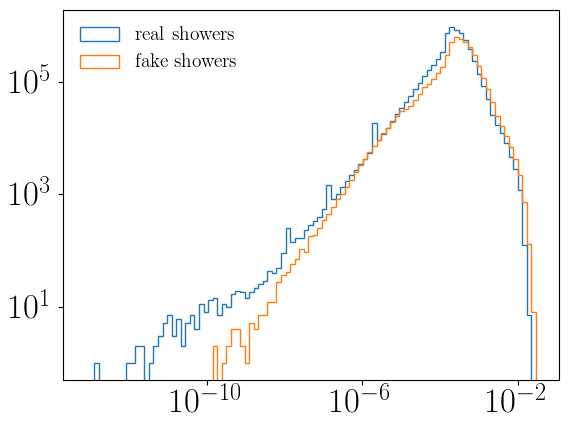

In [63]:
# log bins 
bins = np.logspace(np.log10(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0].min()),np.log10(real_showers[:,-1,:].max()), 100)
plt.hist(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0], bins = bins, histtype='step', label='real showers', density=False)
plt.hist(fake_showers_3[:,-1,:][fake_showers_3[:,-1,:] != 0.0], bins = bins, histtype='step', label='fake showers', density=False)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [64]:
# ### CoG shift correction for x and y coordinates
# fake_showers_3[:, 0] = fake_showers_3[:, 0] - (-0.10704701695531388) # calulated as cog_2[0].mean() - cog[0].mean() for 40k samples, E form 10 to 100 GeV
# fake_showers_3[:, 2] = fake_showers_3[:, 2] - (-0.3062229876492353) # calulated as cog_2[2].mean() - cog[2].mean() for 40k samples, E from 10 to 100 GeV

In [65]:
# fake_showers_3[:, 2, :] += 0.216814

In [66]:
fake_showers[:, 0] = fake_showers[:, 0] - (-0.10704701695531388) # calulated as cog_2[0].mean() - cog[0].mean() for 40k samples, E form 10 to 100 GeV
fake_showers[:, 2] = fake_showers[:, 2] - (-0.3062229876492353) # calulated as cog_2[2].mean() - cog[2].mean() for 40k samples, E from 10 to 100 GeV

In [67]:
cog = gen_utils.get_cog(
    real_showers[:, 0],
    real_showers[:, 1],
    real_showers[:, 2],
    real_showers[:, 3],
)

cog_2 = gen_utils.get_cog(
    fake_showers[:, 0],
    fake_showers[:, 1],
    fake_showers[:, 2],
    fake_showers[:, 3],
)

cog_3 = gen_utils.get_cog(
    fake_showers_2[:, 0],
    fake_showers_2[:, 1],
    fake_showers_2[:, 2],
    fake_showers_2[:, 3],
)

cog_4 = gen_utils.get_cog(
    fake_showers_3[:, 0],
    fake_showers_3[:, 1],
    fake_showers_3[:, 2],
    fake_showers_3[:, 3],
)

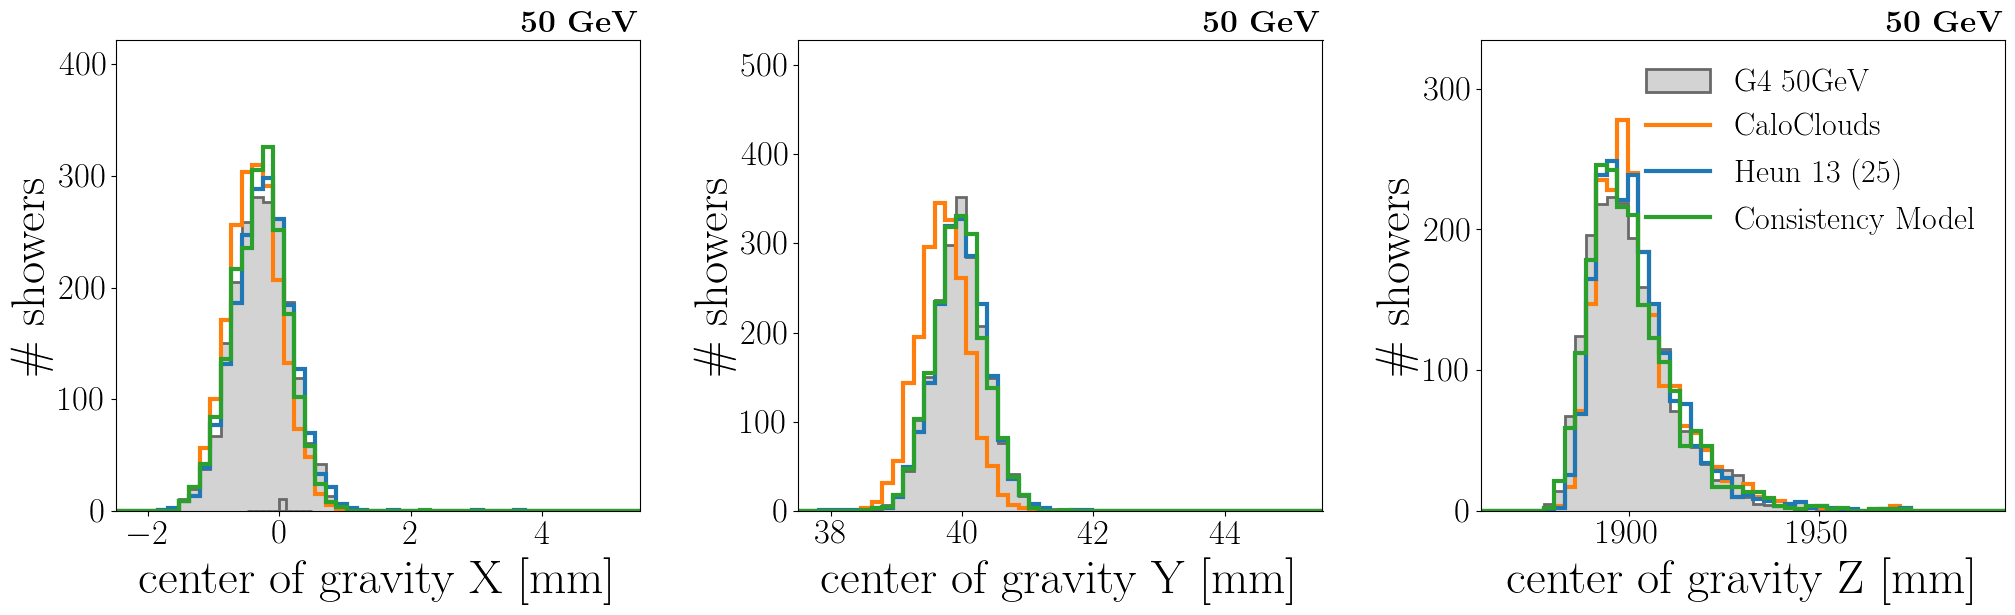

In [68]:
plotting.plt_cog(cog, [cog_2, cog_3, cog_4], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'Consistency Model'], title=r'\textbf{50 GeV}')

In [69]:
cog[2].mean(), cog_2[2].mean(), cog_3[2].mean(), cog_4[2].mean()

(39.969607932835665, 39.708868988695436, 39.9773831615448, 39.95920080757141)

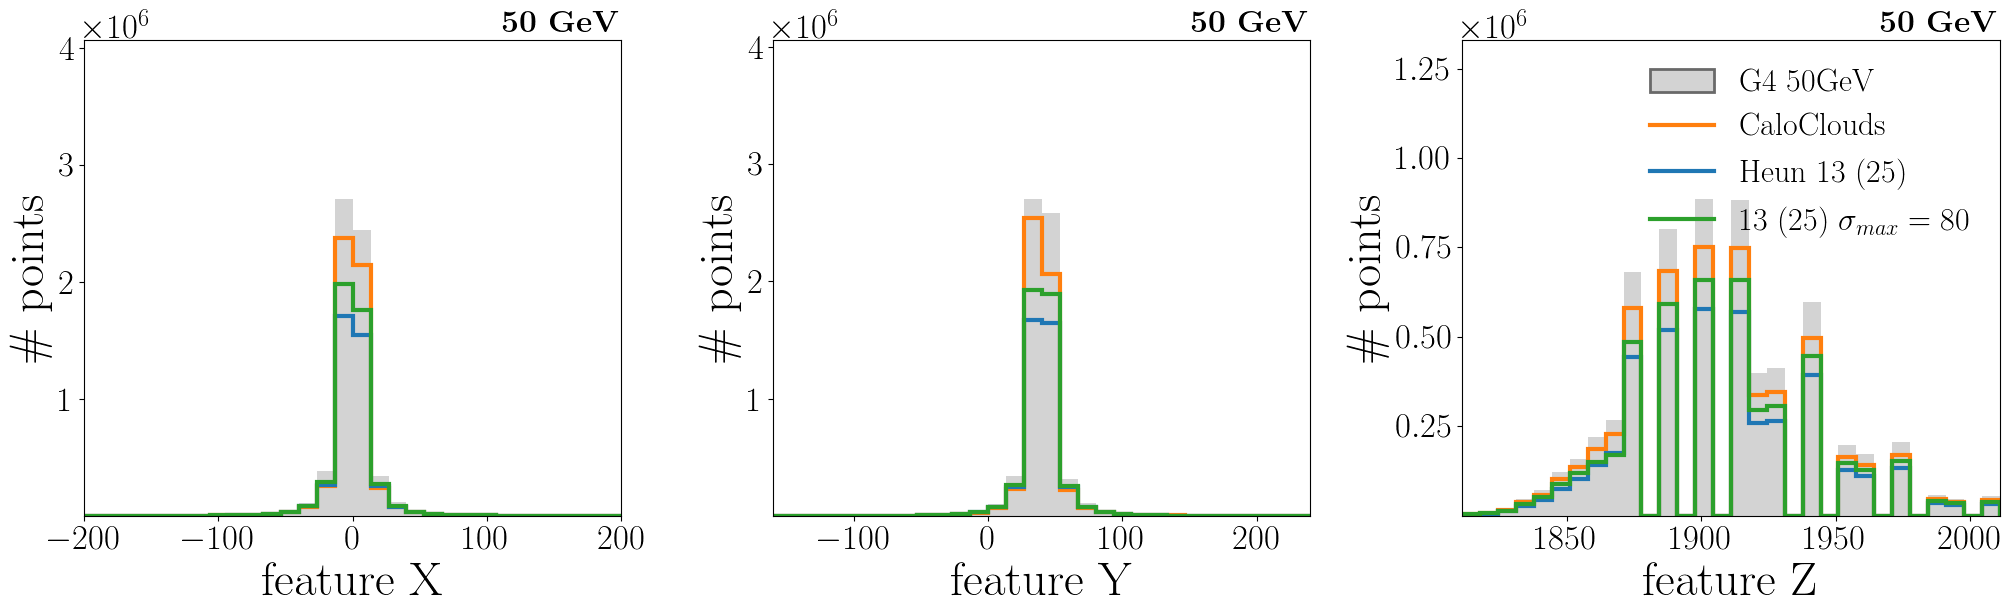

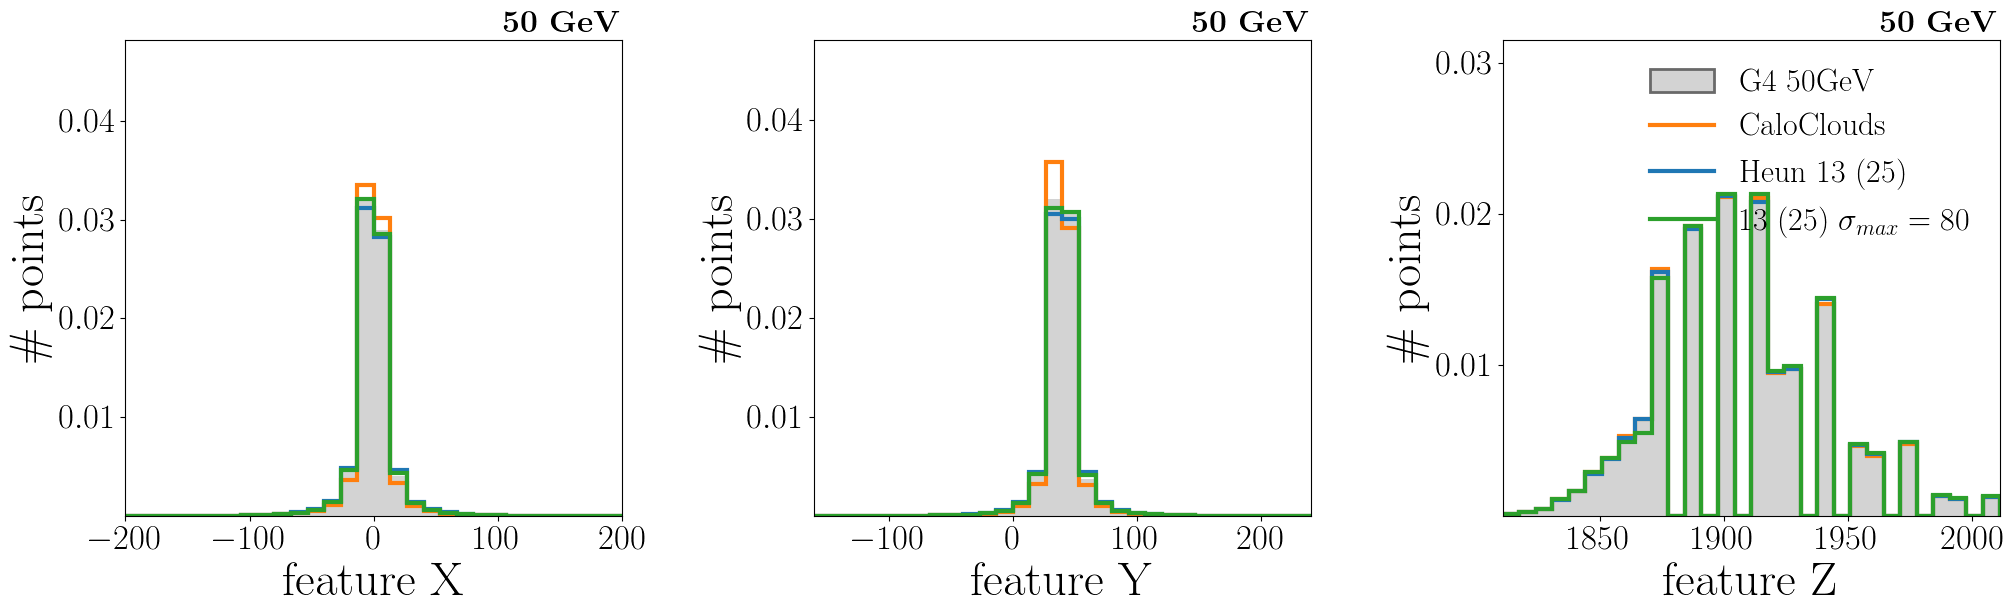

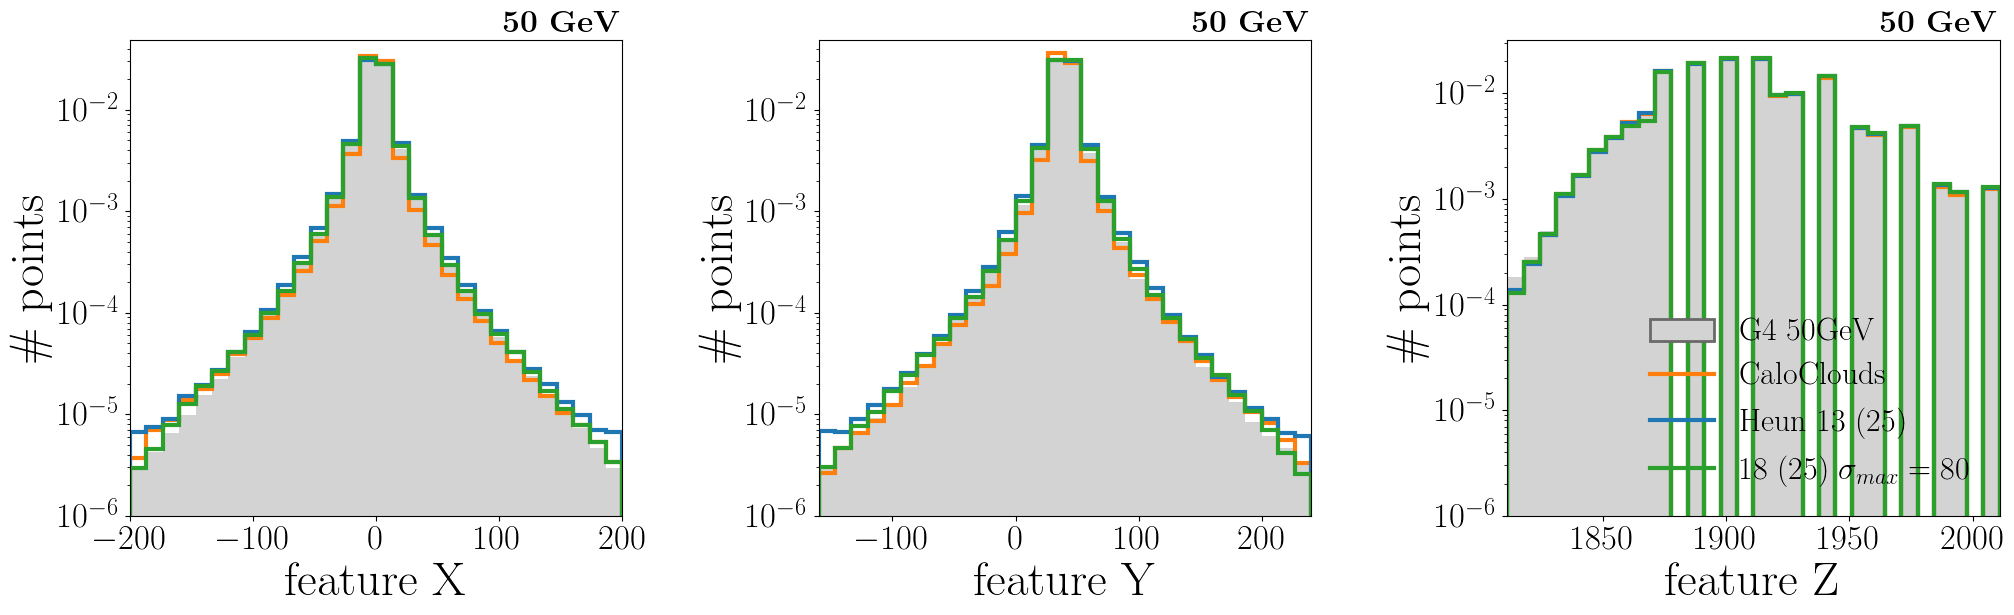

In [70]:
plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=False)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', scale='log', density=True)

In [71]:
cfg.bins_r = 35

In [72]:
events, cloud = get_projections(real_showers, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
events_fake, cloud_fake = get_projections(fake_showers, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
events_fake_2, cloud_fake_2 = get_projections(fake_showers_2, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
events_fake_3, cloud_fake_3 = get_projections(fake_showers_3, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)

100%|██████████| 2000/2000 [00:03<00:00, 535.11it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 281.72it/s]


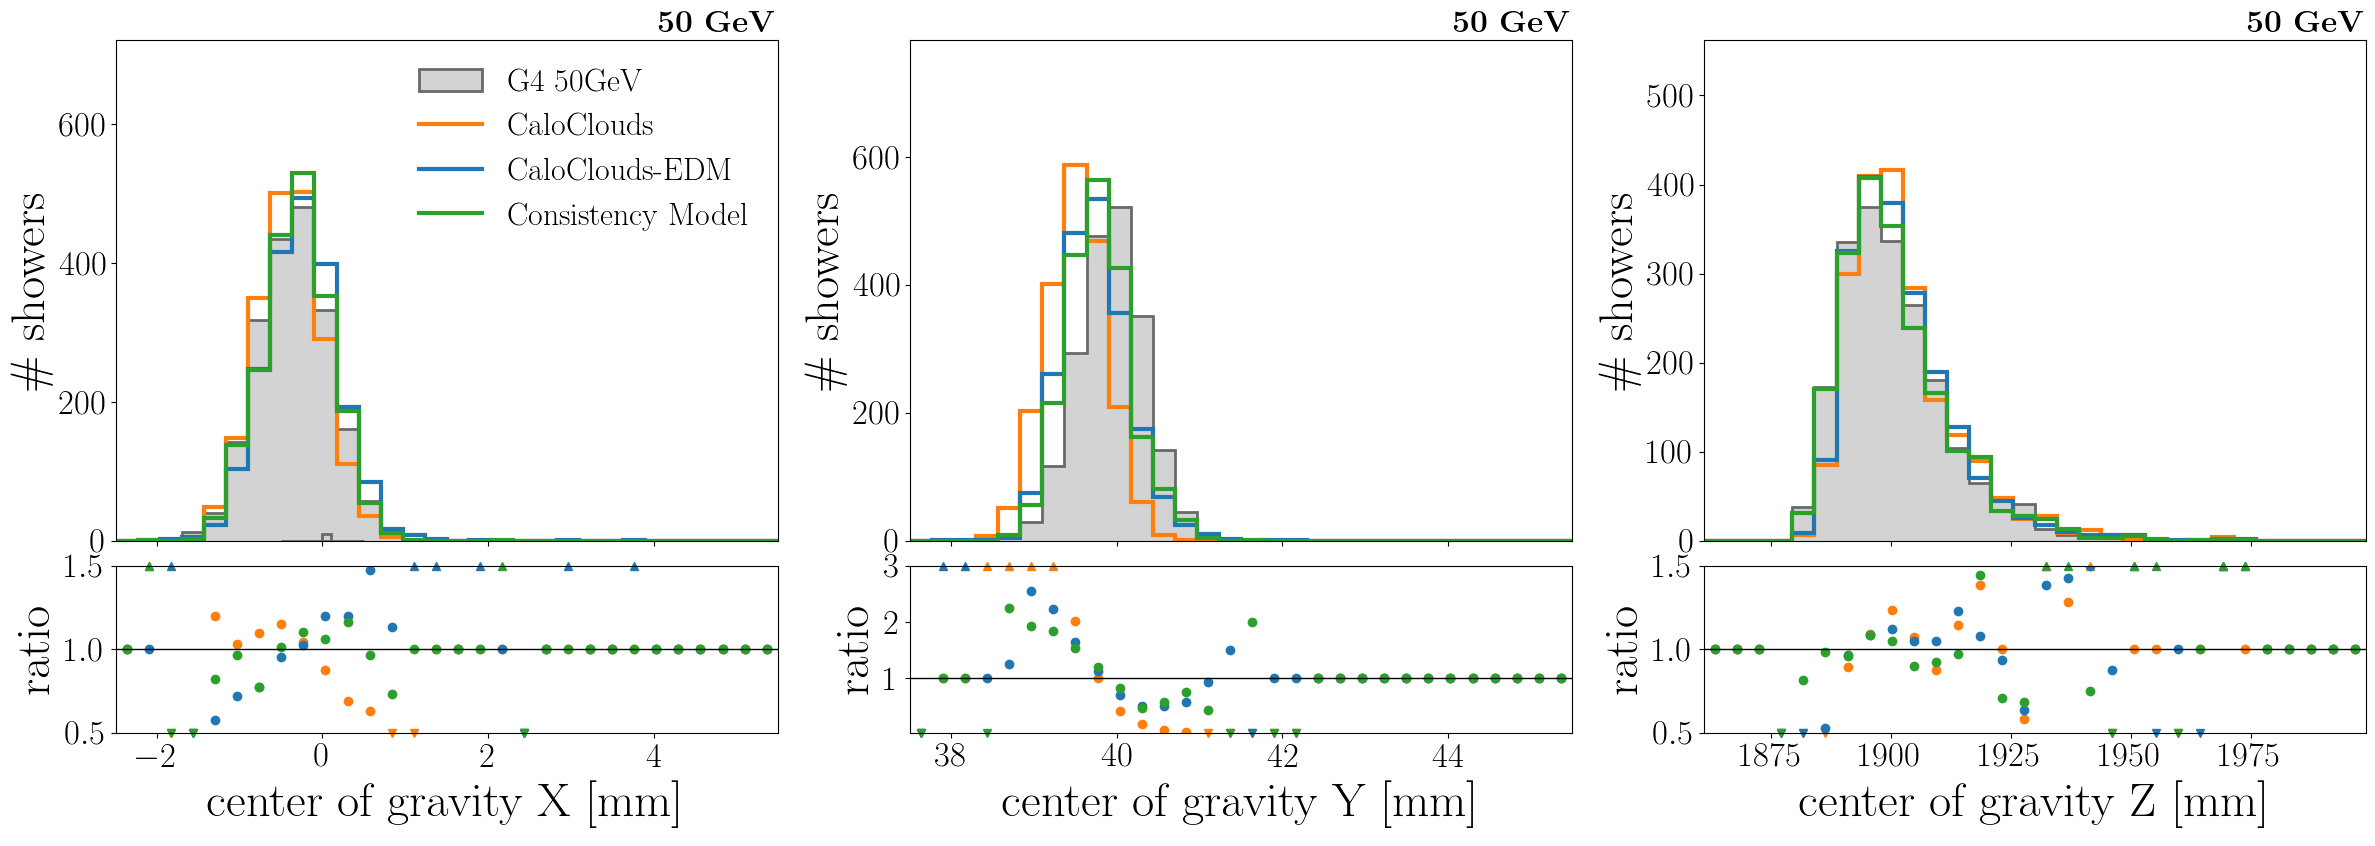

In [165]:
importlib.reload(plotting)

c_cog = gen_utils.get_cog(
    cloud[:, 0],
    cloud[:, 1],
    cloud[:, 2],
    cloud[:, 3],
)

c_cog_2 = gen_utils.get_cog(
    cloud_fake[:, 0],
    cloud_fake[:, 1],
    cloud_fake[:, 2],
    cloud_fake[:, 3],
)

c_cog_3 = gen_utils.get_cog(
    cloud_fake_2[:, 0],
    cloud_fake_2[:, 1],
    cloud_fake_2[:, 2],
    cloud_fake_2[:, 3],
)

c_cog_4 = gen_utils.get_cog(
    cloud_fake_3[:, 0],
    cloud_fake_3[:, 1],
    cloud_fake_3[:, 2],
    cloud_fake_3[:, 3],
)

plotting.plt_cog(c_cog, [c_cog_2, c_cog_3, c_cog_4], ['G4 50GeV', 'CaloClouds', 'CaloClouds-EDM', r'Consistency Model'], title=r'\textbf{50 GeV}')

In [74]:
cog[2].mean(), cog_2[2].mean(), cog_3[2].mean(), cog_4[2].mean()

(39.969607932835665, 39.708868988695436, 39.9773831615448, 39.95920080757141)

In [75]:
c_cog[2].mean(), c_cog_2[2].mean(), c_cog_3[2].mean(), c_cog_4[2].mean()

(39.939273732771156, 39.521482255981475, 39.74700071360709, 39.78126531755873)

In [76]:
print(cog[0].mean(), cog_2[0].mean(), cog_3[0].mean(), cog_4[0].mean())
print(c_cog[0].mean(), c_cog_2[0].mean(), c_cog_3[0].mean(), c_cog_4[0].mean())

-0.2756954336133483 -0.37120954799183836 -0.2424110289812088 -0.29782406211574564
-0.3399506232999559 -0.39175813064305043 -0.24288114977193803 -0.3038764743331416


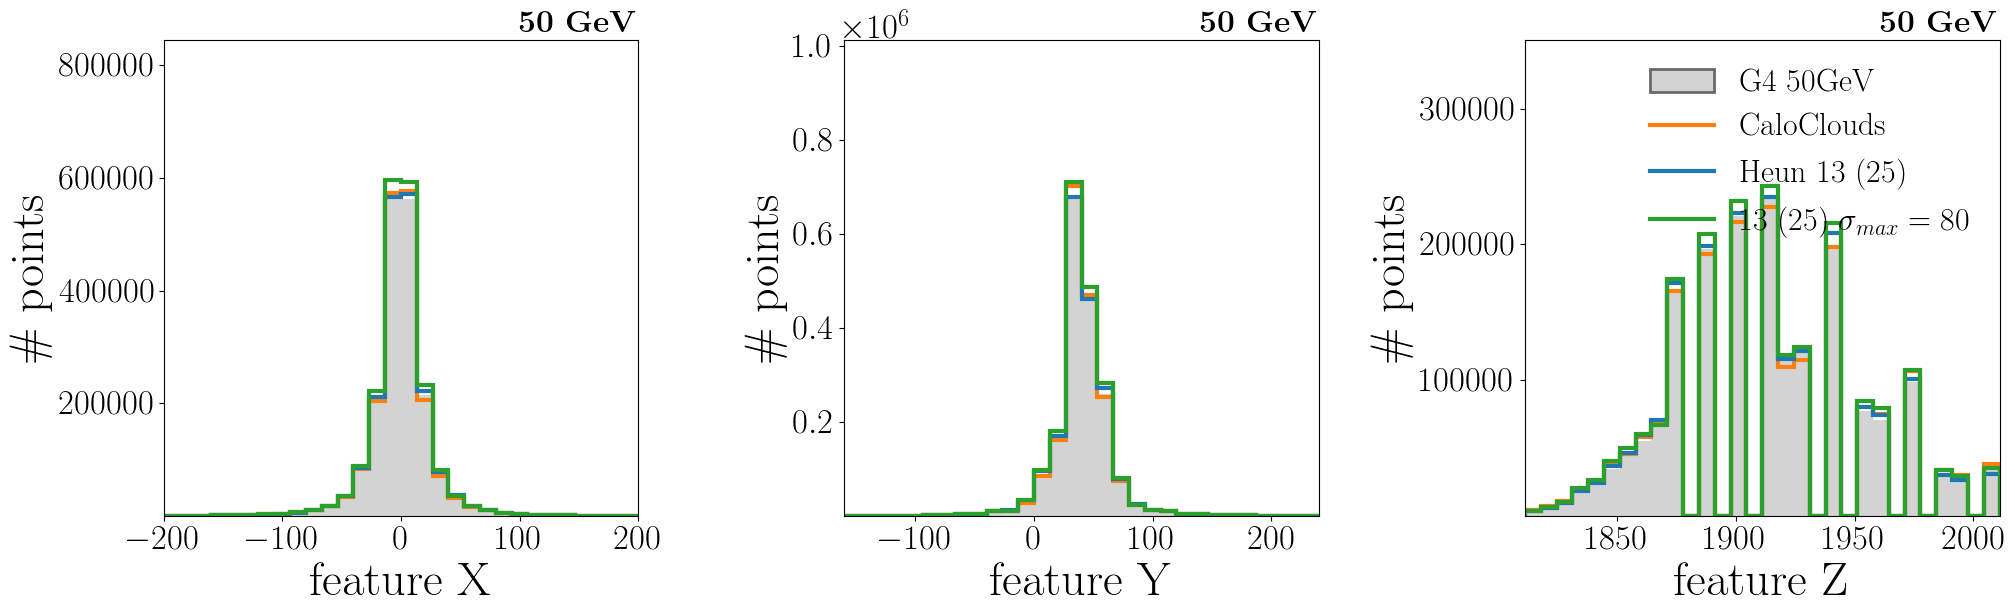

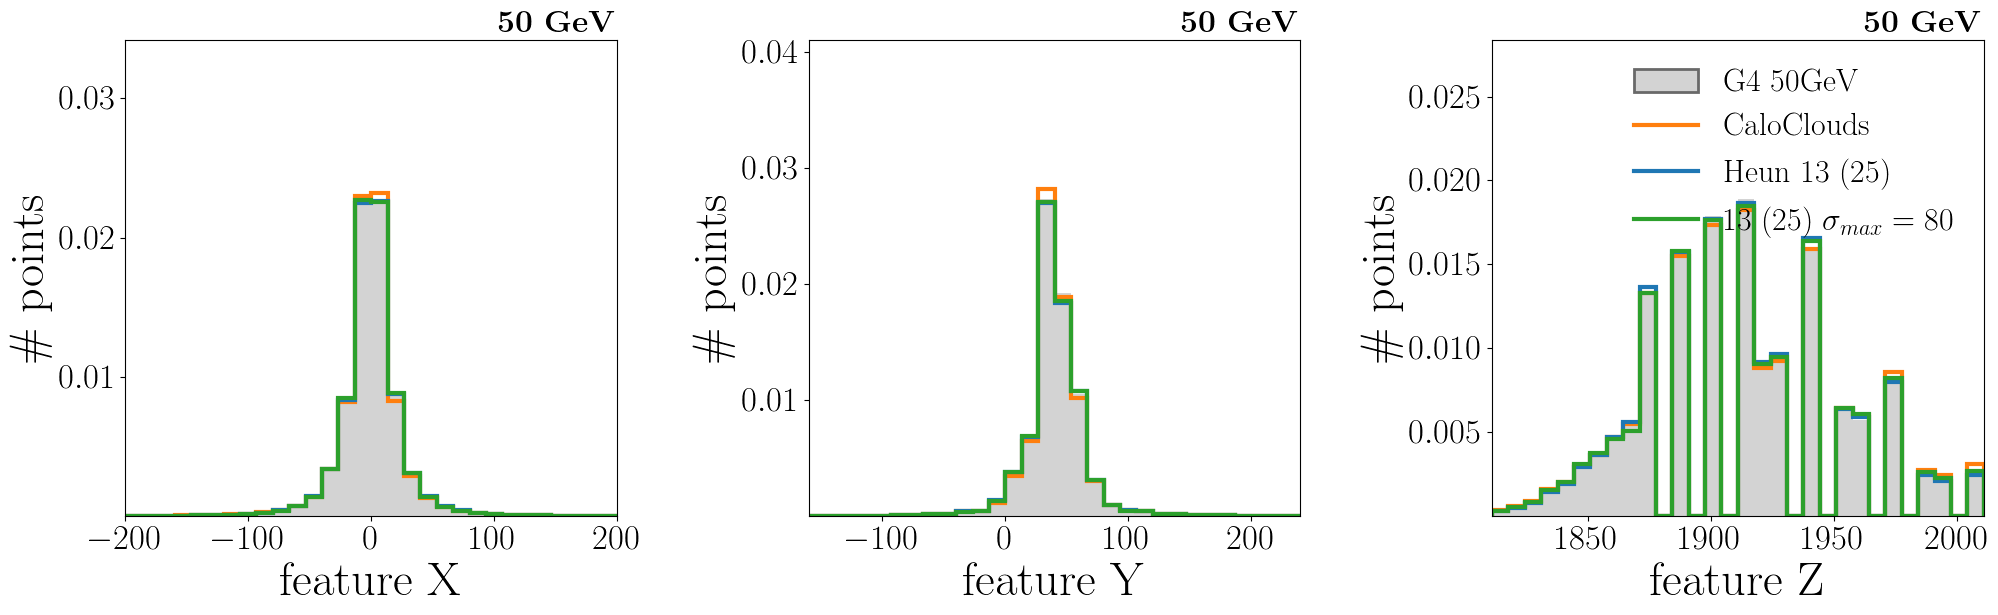

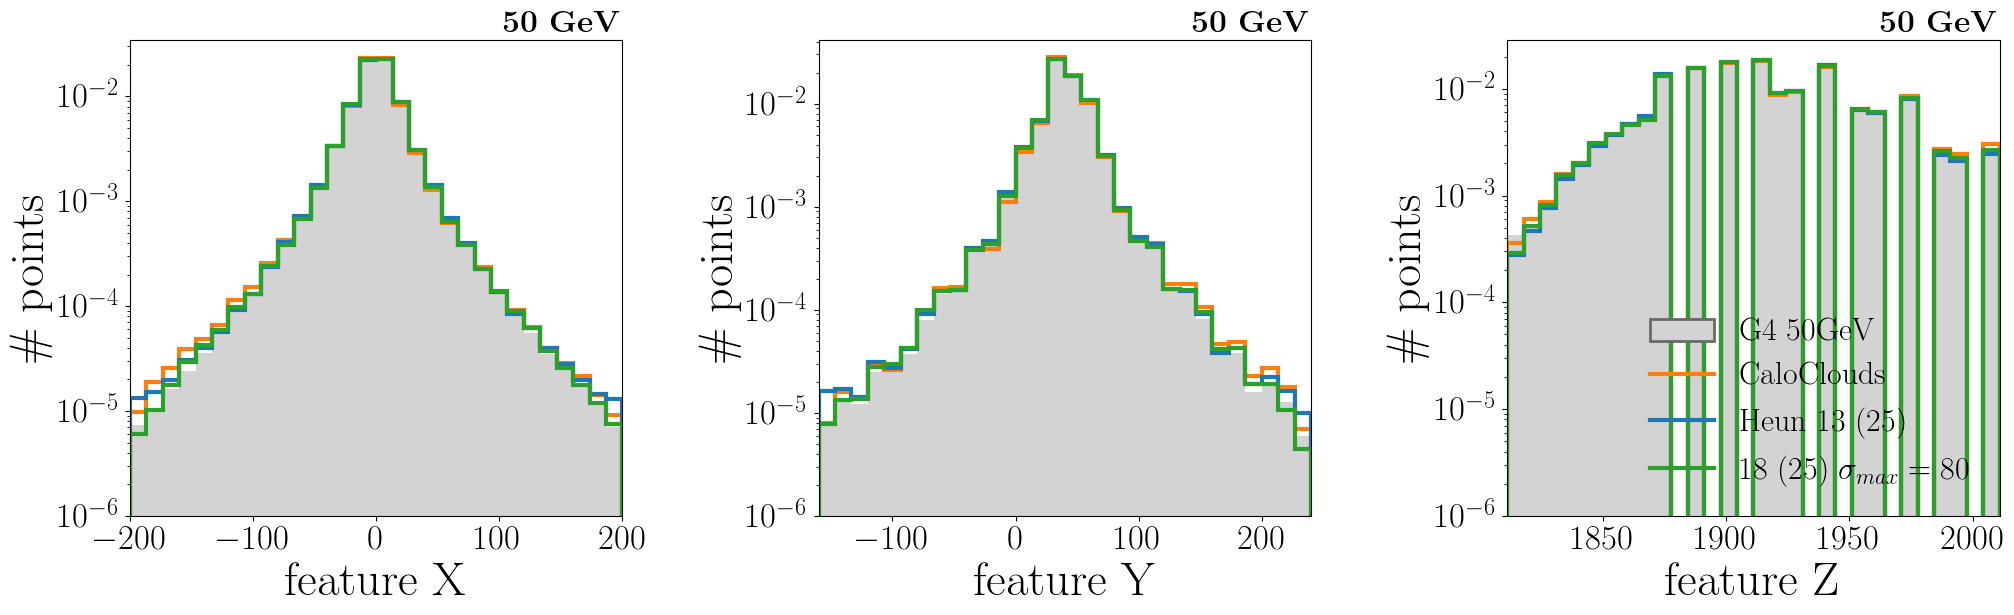

In [77]:
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=False)
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', scale='log', density=True)

100%|██████████| 2000/2000 [00:05<00:00, 350.28it/s]


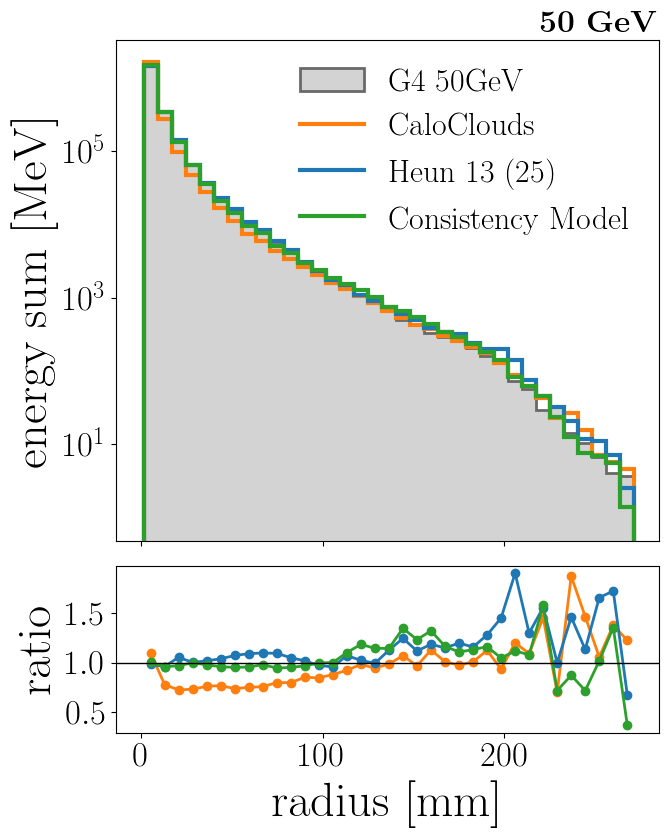

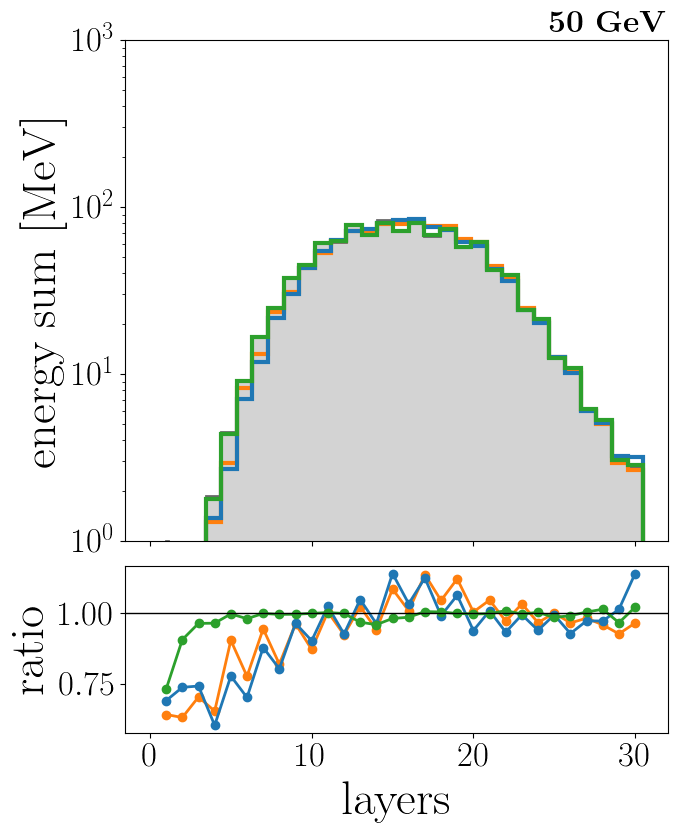

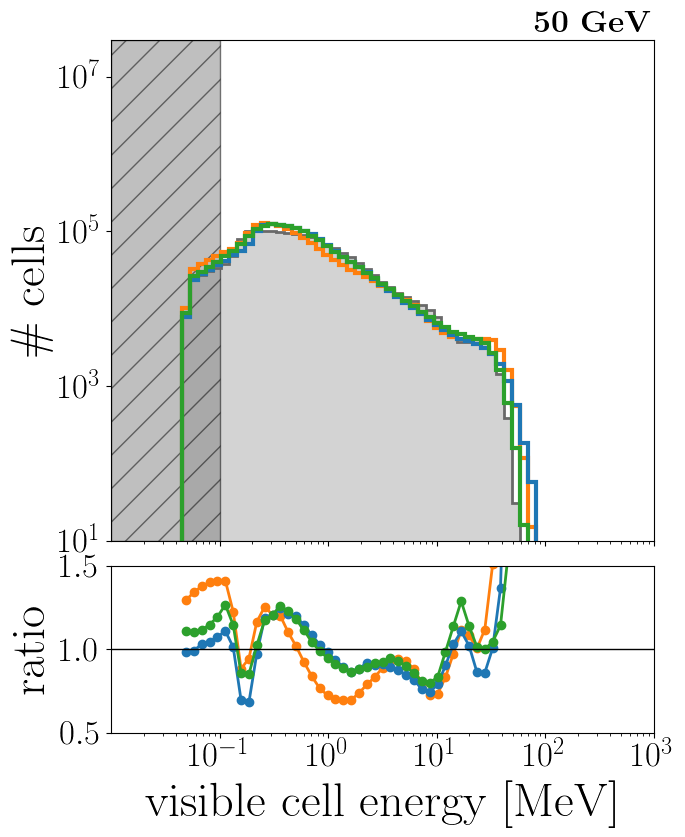

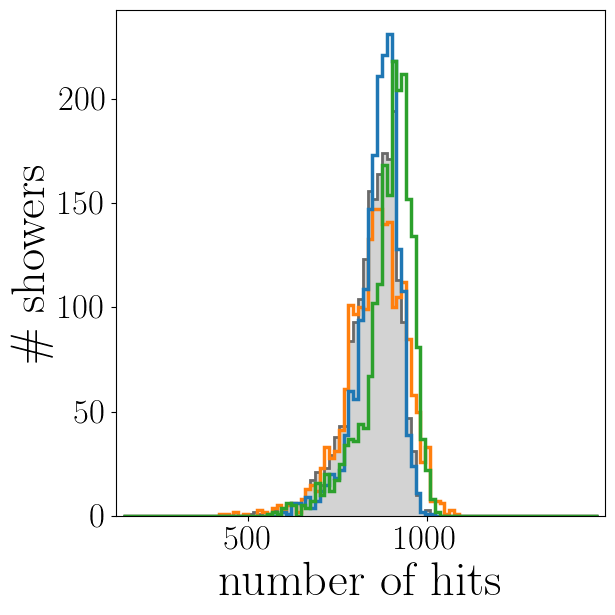

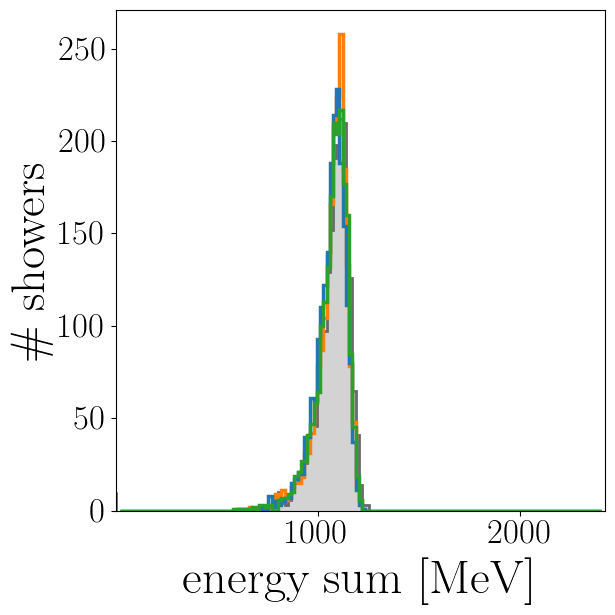

In [82]:
# get_plots(events, [events_fake, events_fake_2],
importlib.reload(plotting)
plotting.get_plots(events, [events_fake, events_fake_2, events_fake_3],
            labels = ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'Consistency Model'],
            title=r'\textbf{50 GeV}',
         )